In [71]:
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from pandas import concat, datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [72]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [88]:
# load dataset
dataset = pd.read_csv("pollution.csv", header=0, index_col=0)
print(dataset.dtypes)
# dataset['date'] = pd.to_datetime(dataset['date'])
# print(dataset.dtypes)
# data = dataset.iloc[:,[0,2]]
# data['ds'] = data['date']
# data['y'] = data['dew']
# data = data.iloc[:,2:]
# print(data.head(10))
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,10,11,12,13,14,15]], axis=1, inplace=True)
# print(reframed.head())

pollution    float64
dew            int64
temp         float64
press        float64
wnd_dir       object
wnd_spd      float64
snow           int64
rain           int64
dtype: object


In [89]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (32783, 1, 8) (32783,)


/home/roxai/.local/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:539: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/roxai/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Train on 8760 samples, validate on 32783 samples
Epoch 1/50
 - 3s - loss: 0.1667 - val_loss: 0.2390
Epoch 2/50
 - 1s - loss: 0.0632 - val_loss: 0.2403
Epoch 3/50
 - 1s - loss: 0.0540 - val_loss: 0.2352
Epoch 4/50
 - 1s - loss: 0.0499 - val_loss: 0.2295
Epoch 5/50
 - 1s - loss: 0.0480 - val_loss: 0.2241
Epoch 6/50
 - 1s - loss: 0.0468 - val_loss: 0.2205
Epoch 7/50
 - 1s - loss: 0.0459 - val_loss: 0.2168
Epoch 8/50
 - 1s - loss: 0.0453 - val_loss: 0.2137
Epoch 9/50
 - 1s - loss: 0.0447 - val_loss: 0.2113
Epoch 10/50
 - 1s - loss: 0.0445 - val_loss: 0.2088
Epoch 11/50
 - 1s - loss: 0.0444 - val_loss: 0.2059
Epoch 12/50
 - 1s - loss: 0.0441 - val_loss: 0.2034
Epoch 13/50
 - 1s - loss: 0.0440 - val_loss: 0.2011
Epoch 14/50
 - 1s - loss: 0.0440 - val_loss: 0.1986
Epoch 15/50
 - 2s - loss: 0.0439 - val_loss: 0.1964
Epoch 16/50
 - 2s - loss: 0.0437 - val_loss: 0.1939
Epoch 17/50
 - 1s - loss: 0.0437 - val_loss: 0.1912
Epoch 18/50
 - 1s - loss: 0.0436 - val_loss: 0.1883
Epoch 19/50
 - 1s - loss

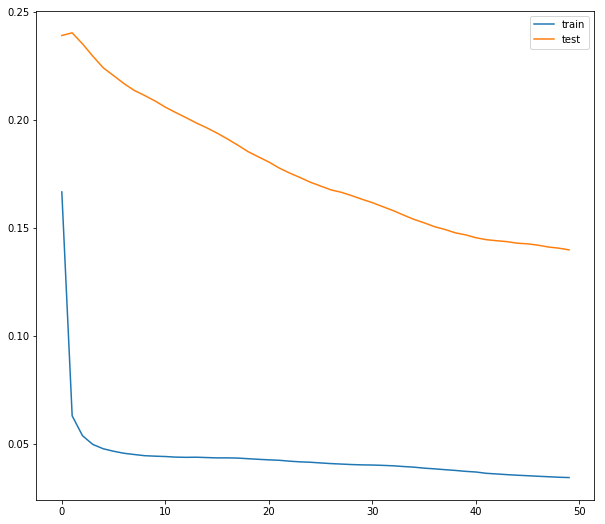

In [90]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [91]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 163.141


618.2606
482.14014


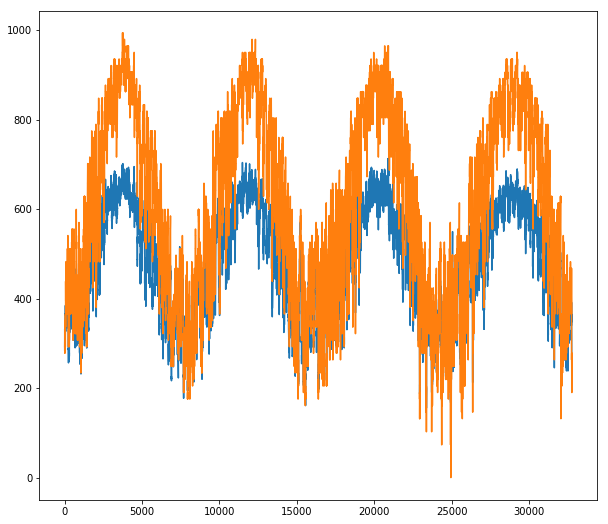

In [92]:
plt.plot()
plt.plot(inv_yhat)
plt.plot(inv_y)
plt.rcParams["figure.figsize"] = [10,9]
plt.savefig("rain.jpg")
print(inv_y.mean())
print(inv_yhat.mean())

4.959101
4.924472


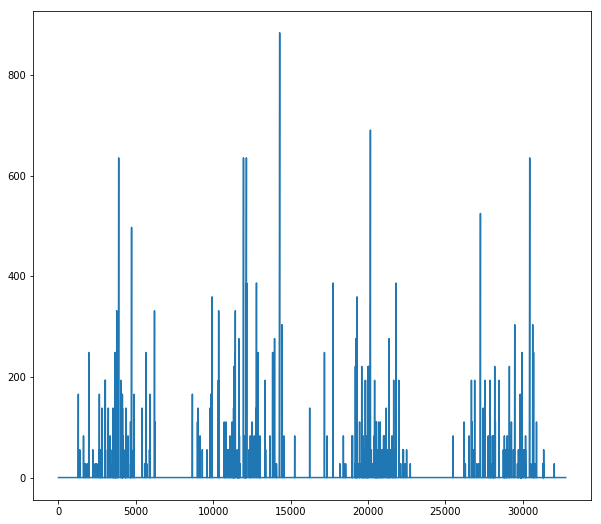

In [47]:
for i in range(5):
    print(inv_yhat[i])

357.5129
278.05576
248.50919
216.63017
216.49547


In [ ]:
data = pd.DataFrame(inv_yhat)

In [ ]:
data['date'] = train_X.iloc[:,0]

In [ ]:
data.shape

Index(['2010-01-01 00:00:00', '2010-01-01 01:00:00', '2010-01-01 02:00:00',
       '2010-01-01 03:00:00', '2010-01-01 04:00:00', '2010-01-01 05:00:00',
       '2010-01-01 06:00:00', '2010-01-01 07:00:00', '2010-01-01 08:00:00',
       '2010-01-01 09:00:00',
       ...
       '2014-12-31 14:00:00', '2014-12-31 15:00:00', '2014-12-31 16:00:00',
       '2014-12-31 17:00:00', '2014-12-31 18:00:00', '2014-12-31 19:00:00',
       '2014-12-31 20:00:00', '2014-12-31 21:00:00', '2014-12-31 22:00:00',
       '2014-12-31 23:00:00'],
      dtype='object', name='date', length=43824)